# Summary of Findings

### Introduction
Within the dataset, extreme weather events are classified by an `ANOMALY.LEVEL`, the Oceanic Niño Index, of greater than or equal to +0.5, or less than or equal to -0.5. An ONI of greater than or equal to +0.5 is considered an 'El Niño' event, causing wetter conditions in the South/East and dryer, warmer conditions in the North/West. An ONI of less than or equal to -0.5 is consider a 'La Niña' event, causing winter temperatures to be warmer than normal in the South and cooler than normal in the North. These are simply categorized by warm or cold respectively within our dataset under `CLIMATE.CATEGORY`. Our goal is to explore correlations between the severity of power outages, the duration of the outage, and the occurences of these weather 'Anomalies'.

### Assessment of Missingness
 In order to assest missingness, a permutation test need to be completed. We were curious on if the missingness of `CAUSE.CATEGORY.DETAIL` was dependant on `CAUSE.CATEGORY`.  
 In our permutation test we defined:
 - Null: `CAUSE.CATEGORY` has the same distribution when `CAUSE.CATEGORY.DETAIL` is missing compared to not missing
 - Alternative: `CAUSE.CATEGORY` has the different distribution when `CAUSE.CATEGORY.DETAIL` is missing compared to  not missing
 - Test Statistic: Total Variation Distance
 - P-Value: 0.0
 - Results: Reject the null hypothesis  

Conclusion:
We found that there was a statistical significance in our p-value which meant that `CAUSE.CATEGORY` has different distributions when `CAUSE.CATEGORY.DETAIL` is missing compared to not missing. When answering our question, used `CAUSE.CATEGORY` in order to determine if the power outages are intentional or unintentional. With the knowledge that `CAUSE.CATEGORY` may depend on `CAUSE.CATEGORY.DETAIL` our hypothesis test may be innaccurate. Since there is missingness in `CAUSE.CATEGORY.DETAIL` we are unsure if the `CAUSE.CATEGORY` is an accurate display.  
 

### Hypothesis Test
How do unintentional power outages under extreme weather events compare to power outages under normal conditions?
- Null: Unintentional power outages which occur during Nino/Nina weather events are similar in severity to outages which occur under normal weather conditions 
- Alternative: Unintentional power outages which occur during Nino/Nina weather events are more severe than outages which occur under normal weather conditions  
  
- Test Statistic:  Signed Difference of Means
- Significance Level: 0.05
- P-Value: ~0.023
- Results: Reject the null hypothesis

Conclusion:  
We conclude that after performing a hypothesis test and measuring the signed difference in means, we reject the null hypothesis which means that we believe that unintentional power outages that occur in extreme weather events are more severe than outages that occur under normal weather conditions.  
Although we reached a conclusion, 

# Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [97]:
# importing the excel file
data = pd.read_excel('outage.xlsx') 
data = data[4:].reset_index(drop=True)

#renaming the column names to match the excel sheet
data.columns = data.iloc[0]

# dropping unneccesary columns
data = data.drop([0]).drop([1]).drop(columns = ['variables', 'OBS', 'MONTH', 'YEAR'])

# combining the time and date into a column
# removing repeating columns
date_s = pd.to_datetime(data['OUTAGE.START.DATE']).apply(lambda x: x.date()).astype(str)
date_r = pd.to_datetime(data['OUTAGE.RESTORATION.DATE']).apply(lambda x: x.date()).astype(str)
data['OUTAGE.START'] = pd.to_datetime(date_s + ' ' + data['OUTAGE.START.TIME'].astype(str), errors='coerce')
data['OUTAGE.RESTORATION'] = pd.to_datetime(date_r + ' ' + data['OUTAGE.RESTORATION.TIME'].astype(str), errors='coerce')
data = data.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])

# time series data
data = data.sort_values('OUTAGE.START').reset_index(drop=True).dropna(subset=['CLIMATE.CATEGORY'])
data.head()

,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,South Carolina,SC,SERC,Southeast,-1.6,cold,severe weather,winter storm,NaN,7440,...,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923,2000-01-23 08:00:00,2000-01-28 12:00:00
1,South Carolina,SC,SERC,Southeast,-1.6,cold,severe weather,winter storm,NaN,6600,...,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923,2000-01-29 22:00:00,2000-02-03 12:00:00
2,Maine,ME,NPCC,Northeast,-1.1,cold,intentional attack,vandalism,NaN,NaN,...,1428,1360,26.7,1.17,0.39,87.176371,12.823629,6.540418,2000-03-14 21:06:00,NaT
3,Texas,TX,TRE,South,-1.1,cold,system operability disruption,transmission interruption,NaN,70,...,2435.3,1539.9,15.2,3.35,0.58,97.258336,2.742036,2.090873,2000-03-18 16:00:00,2000-03-18 17:10:00
4,New Mexico,NM,WECC,Southwest,-1.1,cold,system operability disruption,transmission interruption,NaN,0,...,1928.5,1446.2,3.9,0.68,0.28,99.759849,0.240151,0.240151,2000-03-18 19:08:00,2000-03-18 19:08:00


After our dataset was cleaned, we were interested in looking at `CAUSE.CATEGORY` and all the values within them:  
calling `data['CAUSE.CATEGORY'].unique()` allowed us to view all the different categories.  
After research, we classified:  
Intentional `CAUSE.CATEGORY`: [intentional attack, public appeal, islanding]  
Unintentional `CAUSE.CATEGORY`: [severe weather, system operability disruption, equipment failure, fuel supply emergency]  

In our goal, we wanted to look at unintential causes, therefore, we filtered out the `data` DataFrame with just information with unintentional causes.

In [57]:
# creating unintentional DataFrame
unintentional_cause = ['severe weather', 'system operability disruption', 'equipment failure', 'fuel supply emergency']
unint = data[data['CAUSE.CATEGORY'].isin(unintentional_cause)]

# creating two DataFrames, one with normal weather condition and one that is Nino/Nina
nino_w = unint[unint['CLIMATE.CATEGORY'] != 'normal']
normal_w = unint[unint['CLIMATE.CATEGORY'] == 'normal']

#### Effect of Nino Event

In order to assest the severity of the outage, we want to look at `OUTAGE.DURATION`.  

`OUTAGE.DURATION` gives us the time which the outage started and the time it was restored. 

In [61]:
# severity measured by total outage duration among all customers *normalized*
nino_severity_ser = ((nino_w.groupby('POSTAL.CODE')['OUTAGE.DURATION'].mean()))
nino_sev_df = pd.DataFrame(nino_severity_ser).reset_index()
nino_sev_df = nino_sev_df.rename(columns={'OUTAGE.DURATION':'Nino'})

#### Severity Under Normal Conditions

In [62]:
# severity measured by total outage duration among all customers *normalized*
norm_severity_ser = ((normal_w.groupby('POSTAL.CODE')['OUTAGE.DURATION'].mean()))
norm_sev_df = pd.DataFrame(norm_severity_ser).reset_index() 
norm_sev_df = norm_sev_df.rename(columns={'OUTAGE.DURATION':'Normal'})

In [64]:
# combining the two DataFrames
sev_df = nino_sev_df.merge(norm_sev_df, left_on='POSTAL.CODE', right_on='POSTAL.CODE').dropna()
sev_df.head()

,POSTAL.CODE,Nino,Normal
0,AL,1765.666667,390.000000
1,AR,4394.500000,151.200000
2,AZ,17187.000000,276.750000
3,CA,2300.139535,1669.392157
4,CO,2269.600000,226.666667


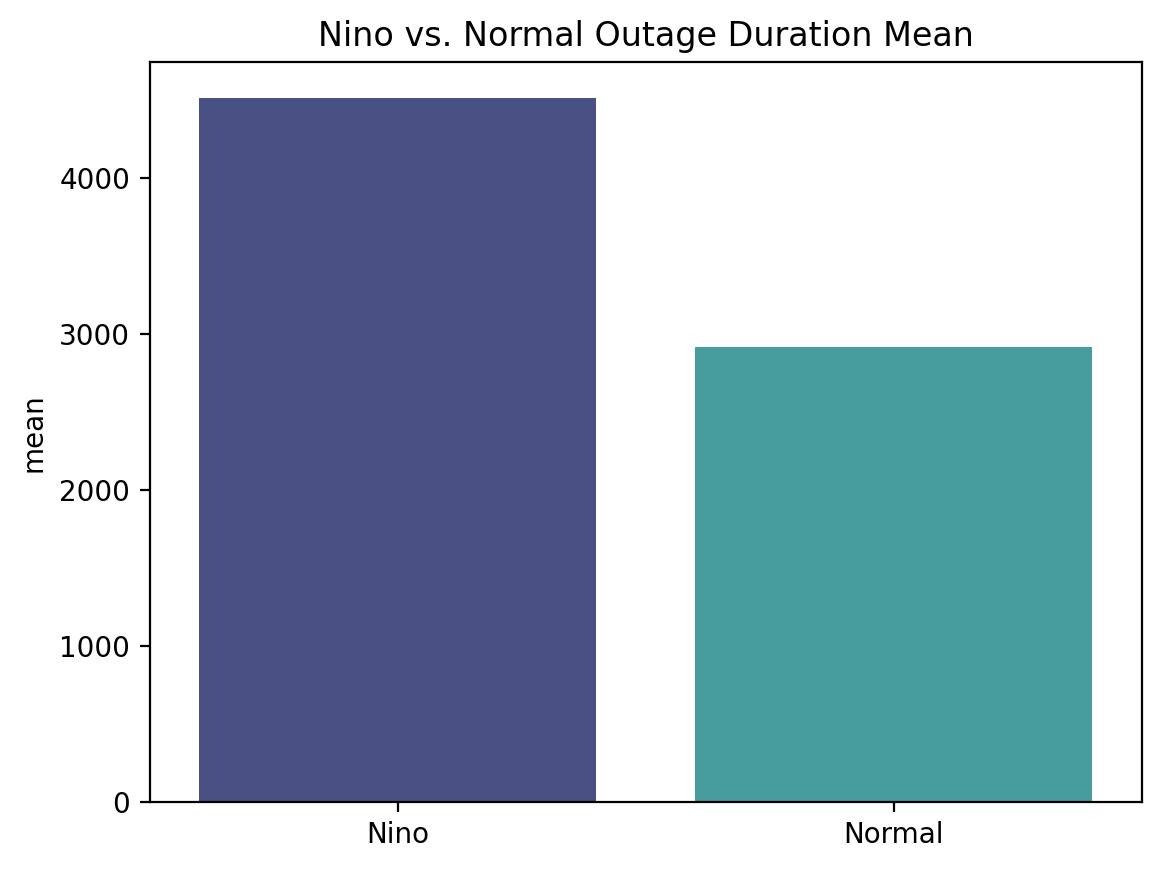

In [65]:
ax = sns.barplot(x=["Nino", "Normal"], y=[sev_df['Nino'].mean(), sev_df['Normal'].mean()], palette='mako');
ax.set(ylabel='mean', title='Nino vs. Normal Outage Duration Mean');

After looking at our barplot, we were able to find that during extreme weather conditions, on average the duration was more severe than under normal weather conditions. However, we further explore if that is just by chance with our hypothesis testing later on. 

### Assessment of Missingness

To assest missingness, we used permuatation testing.

In [46]:
# find the distribution size distrbution of missingness
cat_dist = (
    data
    .assign(detail_missing=data['CAUSE.CATEGORY.DETAIL'].isna())
    .pivot_table(index='CAUSE.CATEGORY', columns='detail_missing', aggfunc='size')
)

cat_dist = cat_dist / cat_dist.sum()
cat_dist

detail_missing,False,True
CAUSE.CATEGORY,,
equipment failure,0.045155,0.025478
fuel supply emergency,0.030103,0.040340
intentional attack,0.348071,0.101911
islanding,NaN,0.097665
public appeal,NaN,0.146497
severe weather,0.541863,0.397028
system operability disruption,0.034807,0.191083


We will use the test statistic of Total Variation Distribution (TVD) because we are working with categorical variables.

In [76]:
# find the data that is missing in cause category detail
shuffled = data.copy()
shuffled['CAUSE.CATEGORY.DETAIL.MISSING'] = shuffled['CAUSE.CATEGORY.DETAIL'].isna()

# repeat TVD 500 times
n_repetitions = 500
tvds = []
for _ in range(n_repetitions):
    
    # shuffled cause.category and put them into the dataframe
    shuffled['CAUSE.CATEGORY'] = np.random.permutation(shuffled['CAUSE.CATEGORY'])
    
    # compute TVD
    pivoted = (
        shuffled
        .pivot_table(index='CAUSE.CATEGORY.DETAIL.MISSING', columns='CAUSE.CATEGORY', aggfunc='size')
        .apply(lambda x: x / x.sum(), axis=1)
    )
    
    # take the True values and store 
    tvd = pivoted.diff().iloc[-1].abs().sum() / 2
    tvds.append(tvd)


In [85]:
# calculate the observed TVD
obs_tvd = cat_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
obs_tvd

0.2885925544217483

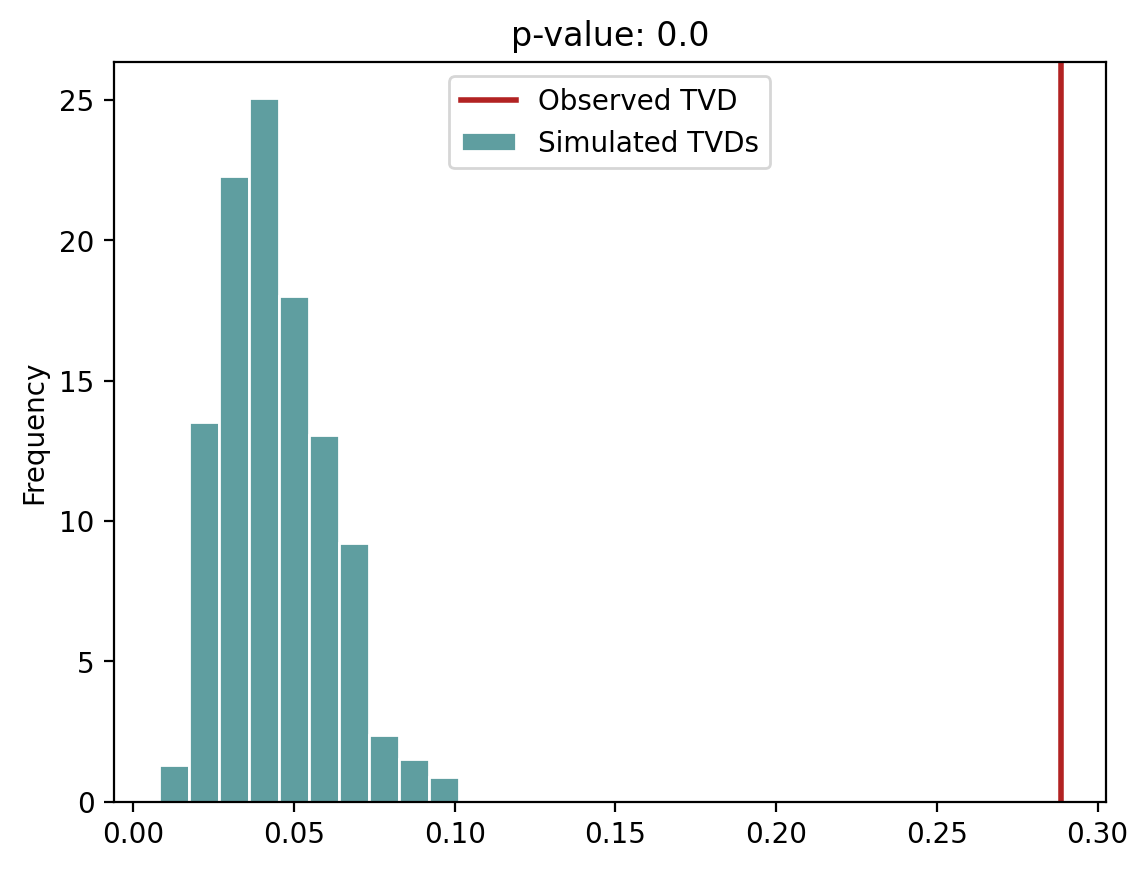

In [90]:
# calculate the p-value
pval = np.mean(tvds >= obs_tvd)

# graph the TVD with the p-value
plt = (pd.Series(tvds).plot(kind='hist', density=True, ec='w', 
                      bins=10, title=f'p-value: {pval}', label='Simulated TVDs', color='cadetblue'))
plt.axvline(x=obs_tvd, color='firebrick', linewidth=2, label='Observed TVD')
plt.legend();

After running our permutation test 500 times, we compared the simulated TVD with the observed TVD and found that our pval is 0.0. 

### Hypothesis Test

Since we are frequently using severe weather and comparing it against normal weather. We have created helper functions where we are able to access DataFrames at our convience. 

In [93]:
def create_nino(df):
    # outputs a DataFrame with extreme weather with the average duration within a state
    nino_w = df[df['CLIMATE.CATEGORY'] != 'normal']
    nino_severity_ser = ((nino_w.groupby('POSTAL.CODE')['OUTAGE.DURATION'].mean()))
    nino_sev_df = pd.DataFrame(nino_severity_ser).reset_index()
    nino_sev_df = nino_sev_df.rename(columns={'OUTAGE.DURATION':'Nino'})
    return nino_sev_df

In [94]:
def create_norm(df):
    # outputs a DataFrame with normal weather with the average duration within the state
    normal_w = df[df['CLIMATE.CATEGORY'] == 'normal']
    norm_severity_ser = ((normal_w.groupby('POSTAL.CODE')['OUTAGE.DURATION'].mean()))
    norm_sev_df = pd.DataFrame(norm_severity_ser).reset_index() 
    norm_sev_df = norm_sev_df.rename(columns={'OUTAGE.DURATION':'Normal'})
    return norm_sev_df

We ran a hypothesis test using difference in means. We used difference in means as a test statistic since our alternative hypothesis was directional. 

In [95]:
unintentional_cause = ['severe weather', 'system operability disruption', 'equipment failure', 'fuel supply emergency']
unint = data[data['CAUSE.CATEGORY'].isin(unintentional_cause)]

# run a hypothesis test
diff_averages = []
nino_avg_obs = create_nino(unint)['Nino'].mean()
norm_avg_obs = create_norm(unint)['Normal'].mean()
obs = (nino_avg_obs - norm_avg_obs)
    
cop = unint.copy()
for i in range(1000):
    cop['OUTAGE.DURATION'] = unint['OUTAGE.DURATION'].sample(992).values
    nino_avg = create_nino(cop)['Nino'].mean()
    norm_avg = create_norm(cop)['Normal'].mean()
    diff_averages.append(nino_avg - norm_avg)
        
p_val = (np.array(diff_averages) >= obs).mean()
p_val

0.034

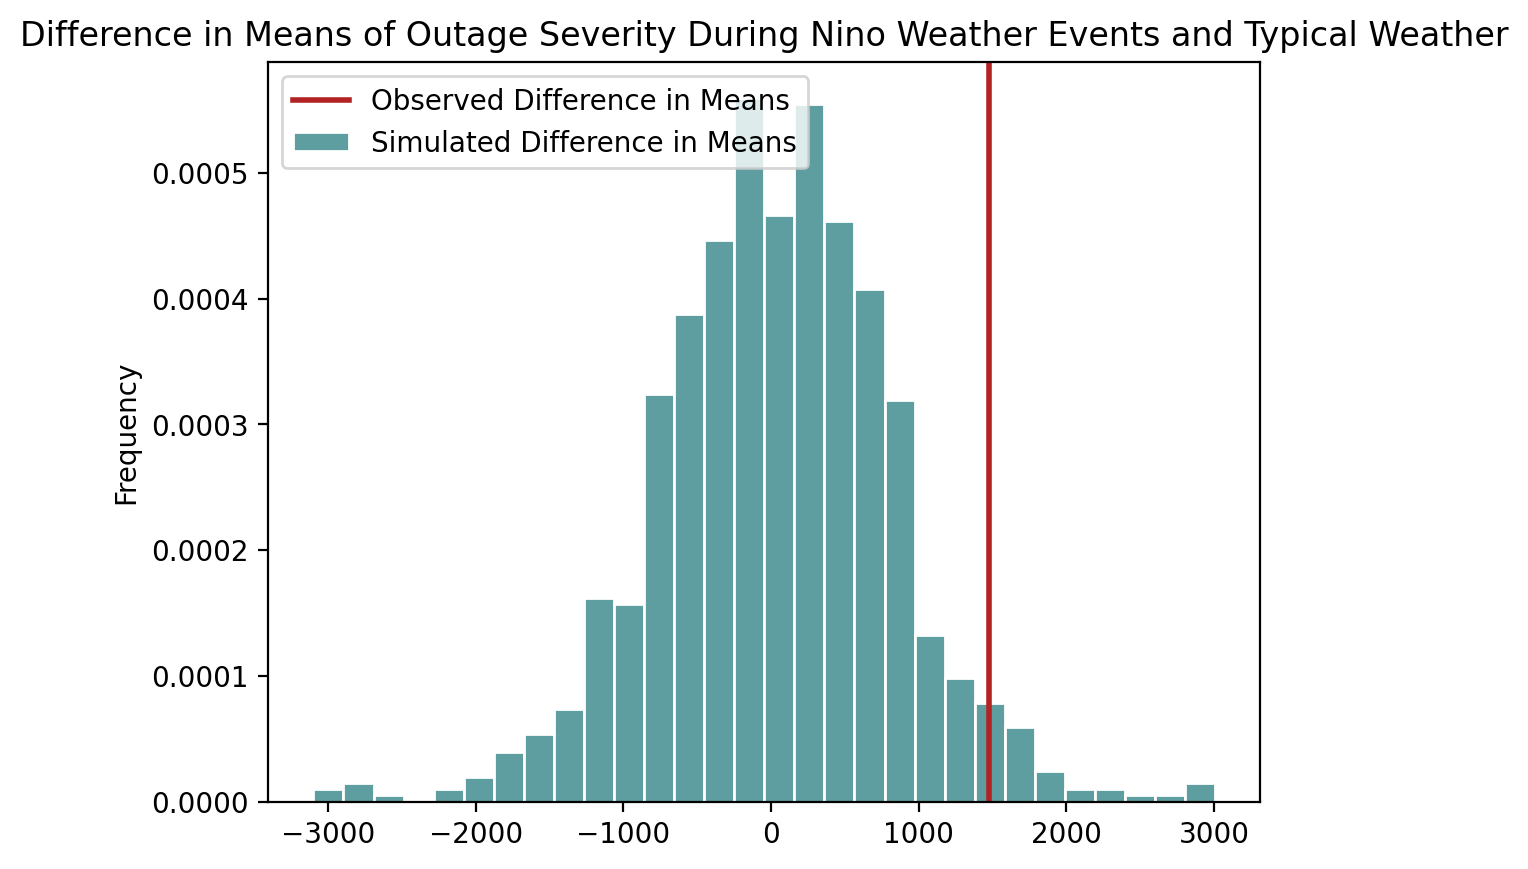

In [98]:
plt = pd.Series(diff_averages).plot(kind='hist', 
                         density=True,
                         bins=30,
                         ec='w',
                         title='Difference in Means of Outage Severity During Nino Weather Events and Typical Weather',
                         color='cadetblue', label='Simulated Difference in Means');

plt.axvline(x=obs, color='firebrick', linewidth=2, label='Observed Difference in Means');
plt.legend();